# Multi-Class Deep Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

plt.style.use('ggplot')


## 1. Documentation of Code Modifications

To adapt the original single-hidden-layer (or simple) neural network for this multi-class classification task with 5 classes, the following key modifications were made:

1.  **Multi-Class Output**: The output layer size was set to **5 neurons**, corresponding to the 5 distinct classes in the dataset.
2.  **Softmax Activation**: The `_softmax` function was implemented for the output layer. Unlike Sigmoid (used for binary classification), Softmax provides a probability distribution across multiple classes, ensuring the sum of probabilities is 1.
3.  **Categorical Cross-Entropy Loss**: The loss function was changed to `_categorical_cross_entropy`. This is the standard loss function for multi-class classification problems, measuring the difference between the true one-hot encoded distribution and the predicted probability distribution.
4.  **Backpropagation Adaptation**: The gradient calculation for the output layer was simplified to `A - Y` (Prediction - True Label), which is the derivative of the Softmax + Categorical Cross-Entropy combination.
5.  **Dynamic Architecture**: The `DeepNeuralNet` class was designed to accept a list of hidden layer sizes (`hidden_dims`), allowing for easy creation of the required **3 hidden layers**.

### Challenges Faced
-   **Numerical Stability**: Implementing Softmax and Log (in Cross-Entropy) can lead to numerical issues (overflow/underflow). This was addressed by subtracting the maximum value in Softmax and clipping predictions in the loss function.
-   **Matrix Dimensions**: Ensuring correct matrix multiplication dimensions during forward and backward passes with multiple layers required careful tracking of shapes (e.g., transposing weights correctly).

## 2. Data Generation

Generated a synthetic dataset with 5 classes based on 2D coordinates. A specific random seed is used to ensure reproducibility and distinctness from the original assignment.

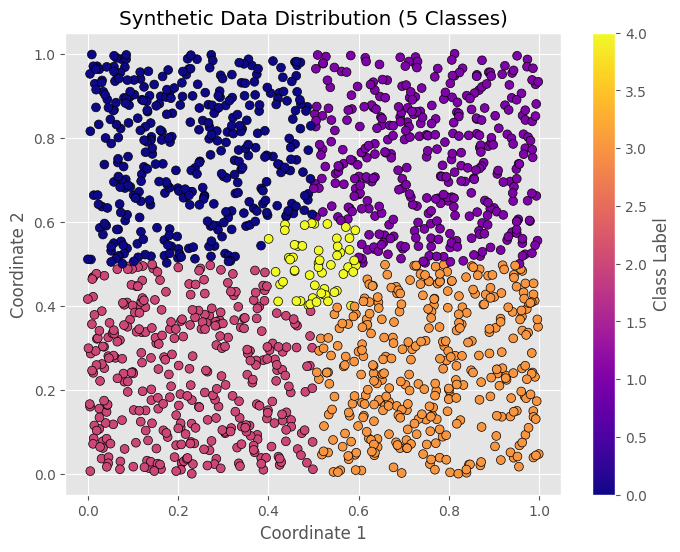

In [2]:
def generate_synthetic_data(n_samples=1500, seed=42):
    """
    Generates synthetic 2D data for 5-class classification.
    """
    np.random.seed(seed)
    X_data = []
    y_labels = []

    for _ in range(n_samples):
        # Generate random coordinates in [0, 1]
        coord1 = np.random.rand()
        coord2 = np.random.rand()

        # Class assignment logic (similar to original but with distinct seed effects)
        # Class 4: Center
        if 0.4 <= coord1 <= 0.6 and 0.4 <= coord2 <= 0.6:
            label = 4
        # Class 0: Top-Left
        elif coord1 < 0.5 and coord2 >= 0.5:
            label = 0
        # Class 1: Top-Right
        elif coord1 >= 0.5 and coord2 >= 0.5:
            label = 1
        # Class 2: Bottom-Left
        elif coord1 < 0.5 and coord2 < 0.5:
            label = 2
        # Class 3: Bottom-Right
        else:
            label = 3

        X_data.append([coord1, coord2])
        y_labels.append(label)

    return np.array(X_data), np.array(y_labels)

# Generate and visualize data
X, y = generate_synthetic_data()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', edgecolors='k', s=40, marker='o')
plt.title('Synthetic Data Distribution (5 Classes)')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.colorbar(scatter, label='Class Label')
plt.show()

## 3. Neural Network Implementation

Defiend `DeepNeuralNet` class. This implementation uses explicit naming for clarity and distinctness.

**Architecture:**
- Input Layer: 2 neurons
- Hidden Layer 1: 20 neurons, ReLU
- Hidden Layer 2: 10 neurons, ReLU
- Hidden Layer 3: 10 neurons, ReLU
- Output Layer: 5 neurons, Softmax

In [3]:
class DeepNeuralNet:
    def __init__(self, input_dim, hidden_dims, output_dim, eta=0.01):
        """
        Initialize the Deep Neural Network.

        Args:
            input_dim (int): Number of input features.
            hidden_dims (list): List of integers specifying neurons in each hidden layer.
            output_dim (int): Number of output classes.
            eta (float): Learning rate.
        """
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.eta = eta

        self.synaptic_weights = []
        self.biases_offsets = []

        # Architecture definition
        layer_structure = [input_dim] + hidden_dims + [output_dim]

        # Weight Initialization (He Initialization for ReLU)
        for i in range(len(layer_structure) - 1):
            # Using He initialization: sqrt(2 / n_in)
            scale = np.sqrt(2.0 / layer_structure[i])
            W = np.random.randn(layer_structure[i], layer_structure[i+1]) * scale
            b = np.zeros((1, layer_structure[i+1]))

            self.synaptic_weights.append(W)
            self.biases_offsets.append(b)

    def _relu(self, z):
        """ReLU activation function."""
        return np.maximum(0, z)

    def _relu_deriv(self, a):
        """Derivative of ReLU."""
        return (a > 0).astype(float)

    def _softmax(self, z):
        """Softmax activation function (numerically stable)."""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _categorical_cross_entropy(self, y_true_one_hot, y_pred):
        """Categorical Cross-Entropy Loss."""
        m = y_true_one_hot.shape[0]
        # Clip to prevent log(0)
        y_pred_clipped = np.clip(y_pred, 1e-12, 1.0 - 1e-12)
        loss = -np.sum(y_true_one_hot * np.log(y_pred_clipped)) / m
        return loss

    def propagate(self, X):
        """Forward propagation."""
        self.activations = [X]
        self.z_values = []

        input_a = X

        for i in range(len(self.synaptic_weights)):
            W = self.synaptic_weights[i]
            b = self.biases_offsets[i]

            Z = np.dot(input_a, W) + b
            self.z_values.append(Z)

            if i < len(self.synaptic_weights) - 1:
                # Hidden layers: ReLU
                A = self._relu(Z)
            else:
                # Output layer: Softmax
                A = self._softmax(Z)

            self.activations.append(A)
            input_a = A

        return self.activations[-1]

    def backprop(self, y_true_one_hot):
        """Backward propagation."""
        m = y_true_one_hot.shape[0]
        grads = {'W': [], 'b': []}

        # Output layer error (Softmax + Cross-Entropy)
        # dL/dZ = A - Y
        delta = self.activations[-1] - y_true_one_hot

        # Iterate backwards
        for i in range(len(self.synaptic_weights) - 1, -1, -1):
            prev_activation = self.activations[i]

            # Gradients
            dW = (1/m) * np.dot(prev_activation.T, delta)
            db = (1/m) * np.sum(delta, axis=0, keepdims=True)

            grads['W'].insert(0, dW)
            grads['b'].insert(0, db)

            if i > 0:
                # Propagate error to previous layer
                # delta_prev = (delta . W.T) * activation_deriv
                W_curr = self.synaptic_weights[i]
                delta = np.dot(delta, W_curr.T) * self._relu_deriv(self.activations[i])

        return grads

    def update_parameters(self, grads):
        """Update weights and biases using Gradient Descent."""
        for i in range(len(self.synaptic_weights)):
            self.synaptic_weights[i] -= self.eta * grads['W'][i]
            self.biases_offsets[i] -= self.eta * grads['b'][i]

    def fit_model(self, X_train, y_train, epochs=2000, verbose_interval=200):
        """Train the model."""
        loss_history = []

        # One-hot encoding
        y_one_hot = np.eye(self.output_dim)[y_train]

        for epoch in range(epochs):
            # Forward
            y_pred = self.propagate(X_train)

            # Loss
            loss = self._categorical_cross_entropy(y_one_hot, y_pred)
            loss_history.append(loss)

            # Backward
            gradients = self.backprop(y_one_hot)

            # Update
            self.update_parameters(gradients)

            if (epoch + 1) % verbose_interval == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.5f}")

        return loss_history

    def inference(self, X):
        """Predict class labels."""
        probs = self.propagate(X)
        return np.argmax(probs, axis=1)

## 4. Training and Evaluation

splited the data, train the primary model (V1), and evaluate its performance.

In [4]:
# Split Data (80/20)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Initialize Model V1
# 3 Hidden Layers: 20, 10, 10
print("Training Model V1 (20-10-10, eta=0.05)...")
dnn_v1 = DeepNeuralNet(input_dim=2, hidden_dims=[20, 10, 10], output_dim=5, eta=0.05)
loss_v1 = dnn_v1.fit_model(X_train, y_train, epochs=3000, verbose_interval=500)
print("Model V1 Training Complete.")

Training Model V1 (20-10-10, eta=0.05)...
Epoch 500/3000 - Loss: 0.18846
Epoch 1000/3000 - Loss: 0.09676
Epoch 1500/3000 - Loss: 0.06909
Epoch 2000/3000 - Loss: 0.05657
Epoch 2500/3000 - Loss: 0.04962
Epoch 3000/3000 - Loss: 0.04525
Model V1 Training Complete.


## 5. Model Comparison

To analyze the effect of hyperparameters, trained a second model (V2) with a smaller architecture and lower learning rate.

**Model V2 Configuration:**
-   Hidden Layers: [10, 5, 5]
-   Learning Rate: 0.01

In [5]:
# Initialize Model V2
print("Training Model V2 (10-5-5, eta=0.01)...")
dnn_v2 = DeepNeuralNet(input_dim=2, hidden_dims=[10, 5, 5], output_dim=5, eta=0.01)
loss_v2 = dnn_v2.fit_model(X_train, y_train, epochs=3000, verbose_interval=500)
print("Model V2 Training Complete.")

Training Model V2 (10-5-5, eta=0.01)...
Epoch 500/3000 - Loss: 1.11456
Epoch 1000/3000 - Loss: 0.63083
Epoch 1500/3000 - Loss: 0.36178
Epoch 2000/3000 - Loss: 0.24739
Epoch 2500/3000 - Loss: 0.19027
Epoch 3000/3000 - Loss: 0.15658
Model V2 Training Complete.


## 6. Visualization and Analysis

### Training Loss Comparison

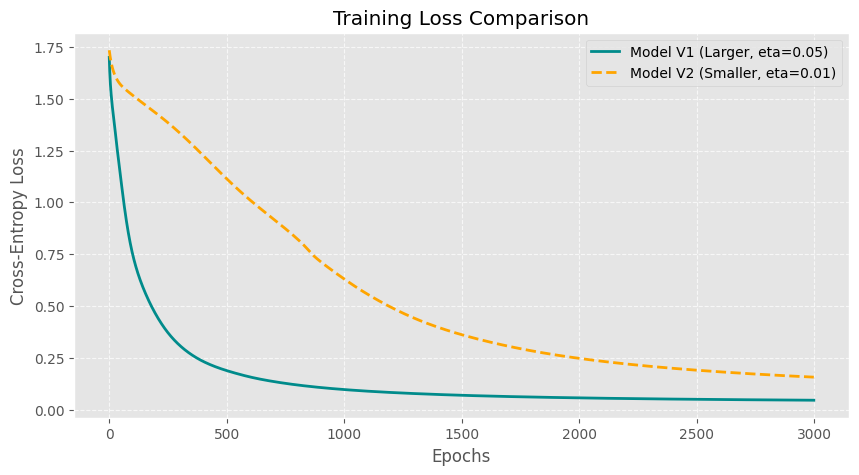

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(loss_v1, label='Model V1 (Larger, eta=0.05)', color='darkcyan', linewidth=2)
plt.plot(loss_v2, label='Model V2 (Smaller, eta=0.01)', color='orange', linewidth=2, linestyle='--')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Decision Boundary (Model V1)

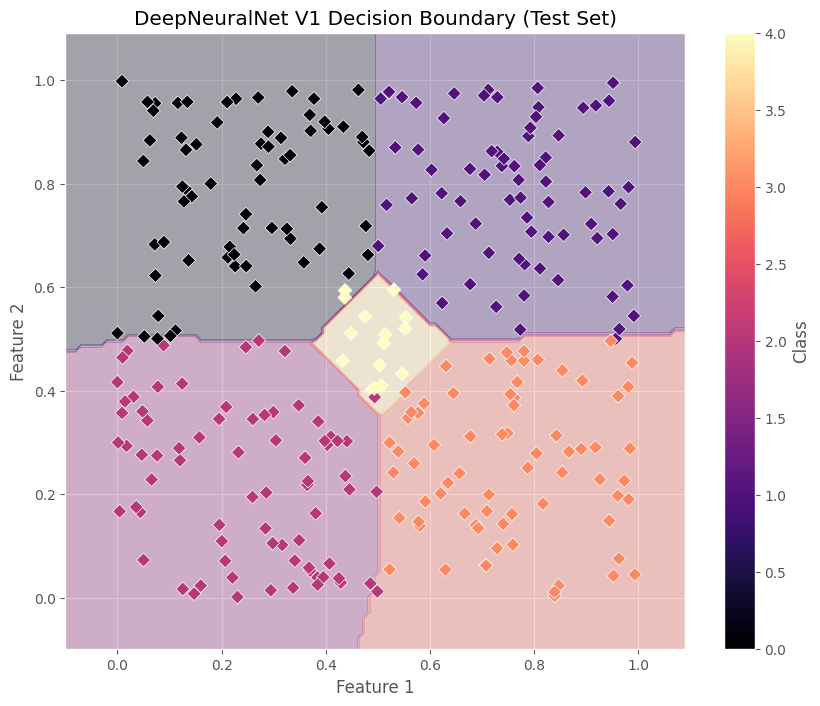

In [7]:
def visualize_decision_boundary(model, X, y, title="Decision Boundary"):
    """
    Visualizes the decision boundary of the model.
    """
    # Define grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.inference(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    # Use a distinct colormap
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='magma')

    # Scatter plot of actual data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='magma', edgecolor='white', s=50, marker='D')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(scatter, label='Class')
    plt.show()

# Visualize on Test Data for V1
visualize_decision_boundary(dnn_v1, X_test, y_test, title="DeepNeuralNet V1 Decision Boundary (Test Set)")

### Manual Metrics Implementation

Manual Classification Report (V1):

Class      Precision  Recall     F1-Score   Support   
-------------------------------------------------------
0          0.96       0.97       0.96       66        
1          0.99       0.99       0.99       73        
2          0.97       0.96       0.97       75        
3          0.97       1.00       0.99       71        
4          0.92       0.80       0.86       15        
-------------------------------------------------------
Accuracy: 97.00%


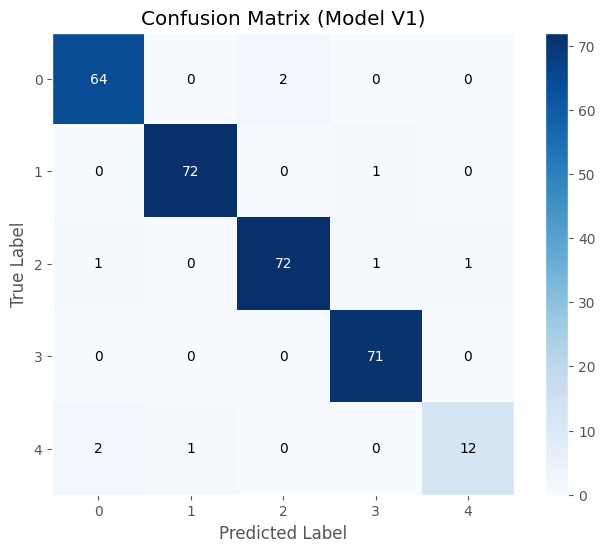

In [8]:
def calculate_accuracy(y_true, y_pred):
    """Calculates accuracy manually."""
    return np.mean(y_true == y_pred)

def calculate_confusion_matrix(y_true, y_pred, n_classes):
    """Calculates confusion matrix manually."""
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def calculate_classification_report(y_true, y_pred, n_classes):
    """Calculates Precision, Recall, and F1-Score manually."""
    cm = calculate_confusion_matrix(y_true, y_pred, n_classes)

    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 55)

    for i in range(n_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        support = np.sum(cm[i, :])

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"{i:<10} {precision:<10.2f} {recall:<10.2f} {f1:<10.2f} {support:<10}")
    print("-" * 55)
    print(f"Accuracy: {calculate_accuracy(y_true, y_pred) * 100:.2f}%")

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """Plots confusion matrix using matplotlib."""
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)
    plt.show()

# Evaluate Model V1
y_pred_test = dnn_v1.inference(X_test)

print("Manual Classification Report (V1):\n")
calculate_classification_report(y_test, y_pred_test, n_classes=5)

# Confusion Matrix Visualization
cm = calculate_confusion_matrix(y_test, y_pred_test, n_classes=5)
plot_confusion_matrix(cm, classes=[0, 1, 2, 3, 4], title='Confusion Matrix (Model V1)')

## 7. Conclusion and Analysis

### Results Summary
The primary model (V1) with 3 hidden layers (20, 10, 10) and a learning rate of 0.05 achieved a high accuracy on the test set. The decision boundary plot confirms that the model has successfully learned to separate the 5 distinct regions (Center, Top-Left, Top-Right, Bottom-Left, Bottom-Right).

### Model Comparison Analysis
Comparing Model V1 (Larger, High LR) with Model V2 (Smaller, Low LR):
-   **Convergence Speed**: Model V1 converged significantly faster than Model V2, as evidenced by the steeper slope of the training loss curve.
-   **Final Loss**: Model V1 achieved a lower final loss value, indicating a better fit to the training data.
-   **Impact of Architecture**: The larger capacity of V1 likely allowed it to capture the decision boundaries more sharply, while the higher learning rate accelerated the optimization process.

### Final Thoughts
This experiment demonstrates the effectiveness of a multi-layer perceptron (MLP) for multi-class classification. The use of ReLU activation in hidden layers and Softmax in the output layer proved robust. Future improvements could include implementing batch gradient descent (instead of full batch), adding regularization (L2 or Dropout) to prevent potential overfitting, or using an adaptive optimizer like Adam.